In [1]:
# import 套件
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score as sil
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 讀入資料
df = pd.read_excel('data.xlsx')
# 把無關的類別型變數剔除
df2 = df.drop(['id','Region','機型'],axis=1)
# 資料標準化
scaler = StandardScaler()
df2 = scaler.fit_transform(df2)

In [3]:
# 設定超參數
eps_values = np.arange(0.25,3,0.25)
min_samples = np.arange(3,23)
DBSCAN_params = list(product(eps_values, min_samples))

In [4]:
# 計算所有超參數組合的 silhouette score (評估聚類算法效果的指標，越接近1，表示聚類結果越好；越接近-1，表示聚類結果越差；接近0則表示樣本處於邊界上，聚類效果不明確)
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(df2)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    try:
        sil_score.append(sil(df2, DBS_clustering.labels_))
    except:
        sil_score.append(0)

A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.


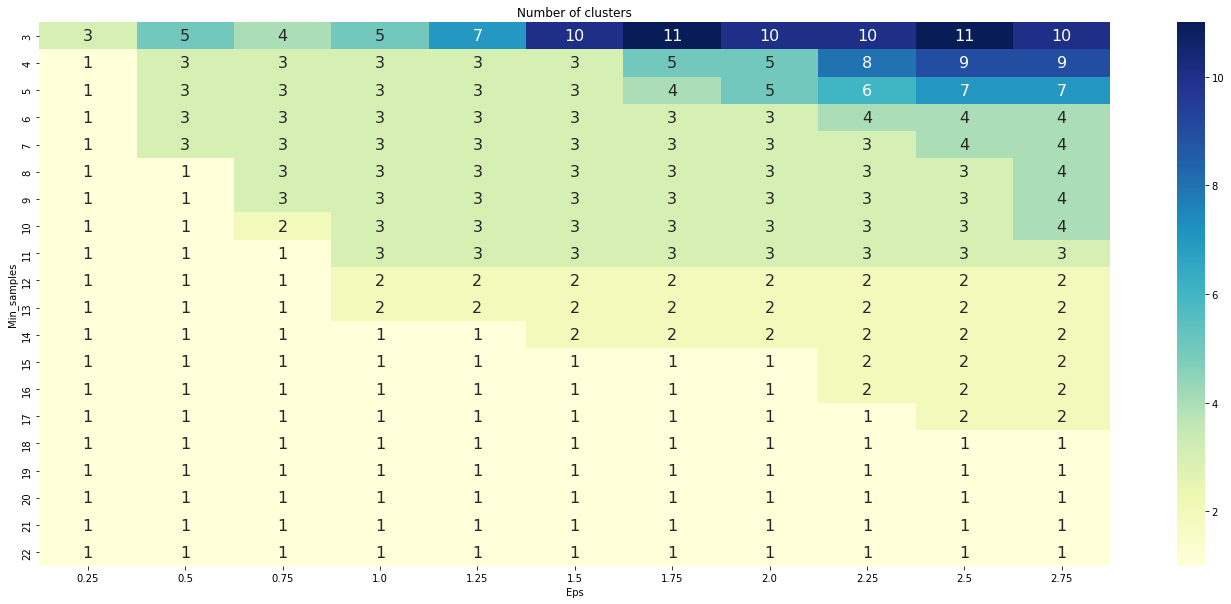

In [5]:
# 決定 eps 和 min_samples 的組合所得到的分群數，顏色越深分類越好
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(24,10))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
print('A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.')
plt.show()

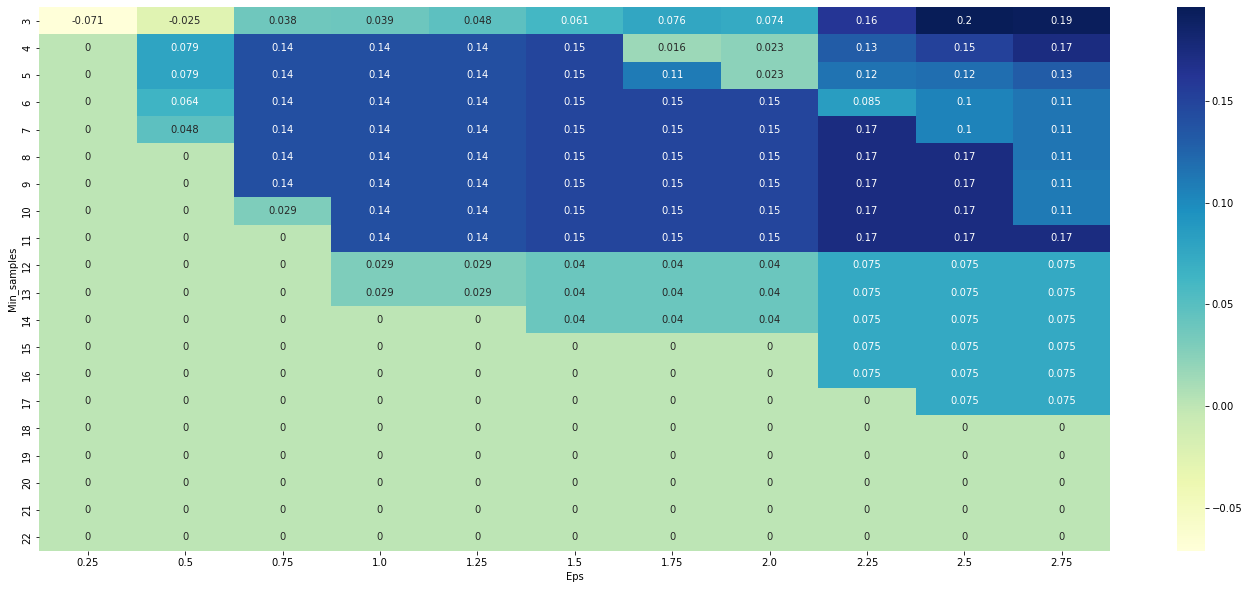

In [6]:
# 決定 eps 和 min_samples 的組合所得到的 silhouette score，顏色越深分類越好
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(24,10))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [7]:
# 自動計算出最佳 silhouette score 下的建議 epsilon 和 min sample
epsilon = [0.25,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75]
min_samples = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(df2)
        #cluster_labels=dbscan.fit_predict(data) 
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        try:
            silhouette_avg = sil(df2, labels)
        except:
            silhouette_avg = 0
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0], 
        "\nmin_sample=", max_value[1],
        "\nnumber of clusters=", max_value[2],
        "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 2.5 
min_sample= 3 
number of clusters= 10 
average silhouette score= 0.1961


In [8]:
# 模型訓練
dbscan = DBSCAN(eps=1, min_samples=3)
dbscan.fit(df2)

DBSCAN(eps=1, min_samples=3)

In [9]:
# 分群結果存到 df_cluster
df_cluster = pd.DataFrame(dbscan.labels_,columns=['cluster'])

In [10]:
# 各分群的數量
df_cluster.value_counts()

cluster
-1         82
 3         13
 0         11
 1          3
 2          3
dtype: int64

In [11]:
# 將分群結果合併入原始資料
df_output = pd.concat([df,df_cluster],axis=1)
df_output

,id,Region,EAS,OC,SEA,EU,NA,Hub,vrste,Crew,...,Yealy schedule fuel cost,Maintainence Cost,Operation Cost,Yearly Flight,Actual Flight per year,Available Seats,Total Passenger,Passenger kilometer,seat kilometer,cluster
0,1,EAS,1,0,0,0,0,1,1.000,7,...,8.333637e+08,3.783379e+08,1.333587e+09,2912,2890,904621,761869,1297462907,1540569563,-1
1,2,EAS,1,0,0,0,0,1,0.956,7,...,4.615502e+08,1.971172e+08,7.620495e+08,1664,1692,565426,491463,717535980,825521960,-1
2,3,OC,0,1,0,0,0,1,0.957,7,...,7.401324e+08,2.948810e+08,3.333967e+08,728,691,220650,141496,953541544,1486960350,-1
3,4,EAS,1,0,0,0,0,0,1.000,8,...,4.208476e+08,1.307491e+08,3.333967e+08,728,810,281788,233716,633837792,764209056,-1
4,5,SEA,0,0,1,0,0,1,0.909,8,...,5.026274e+08,1.613500e+08,3.333967e+08,728,730,260957,217245,703656555,845239723,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,108,EAS,1,0,0,0,0,0,1.000,4,...,3.011432e+07,2.000892e+07,5.806460e+07,208,192,35328,28977,47058648,57372672,3
108,109,EAS,1,0,0,0,0,0,1.000,4,...,9.063037e+07,5.864684e+07,1.451615e+08,520,352,64768,45651,89247705,126621440,3
109,110,EAS,1,0,0,0,0,0,1.000,4,...,5.240336e+07,3.173829e+07,5.806460e+07,208,30,5520,4205,11883330,15599520,3
110,111,EAS,1,0,0,0,0,0,1.000,4,...,2.733282e+07,1.862900e+07,5.806460e+07,208,109,20431,16395,24166230,30115294,3


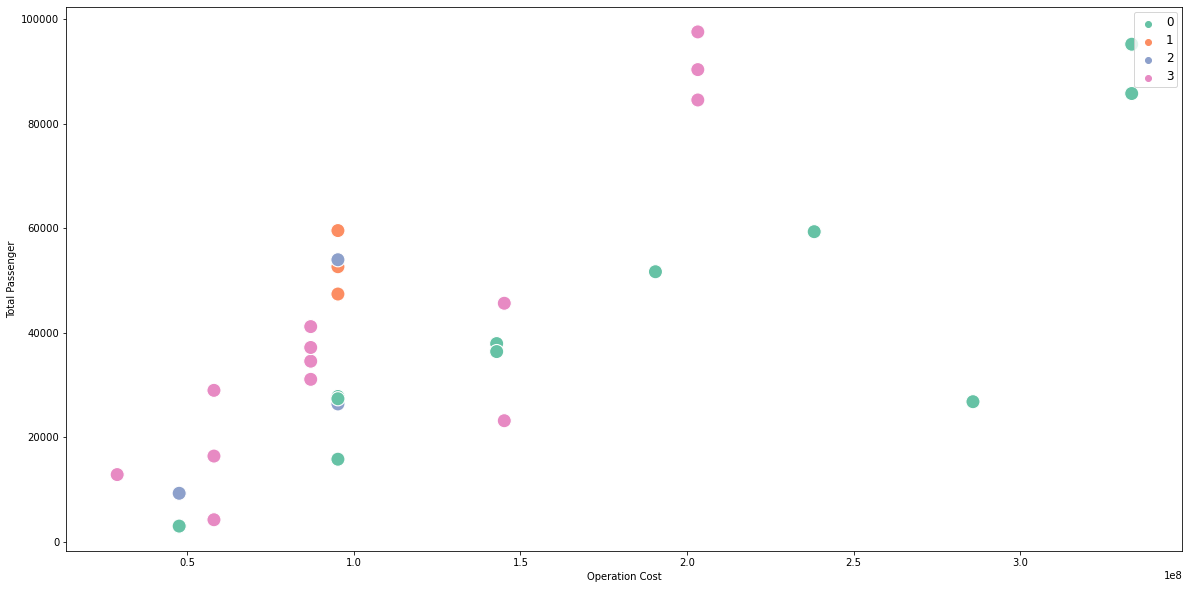

In [12]:
# 任選兩個 features 做分群的視覺化，黑點為 outliers
outliers = df_output[df_output['cluster'] == -1]

fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot('Operation Cost', 'Total Passenger',
                data=df_output[df_output['cluster'] != -1],
                hue='cluster', palette='Set2', legend='full', s=200, ax=ax)

# ax.scatter(outliers['Operation Cost'], outliers['seat kilometer'], s=10, label='outliers', c="k")

ax.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12')

plt.show()